# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 for all logs, 2 for errors only
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from scipy.spatial import ConvexHull

from mpl_toolkits.mplot3d import Axes3D

## Get data

In [2]:
mnist = keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Autoencoder

### training data

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_train.max())
print(x_test.shape)
print(x_test.max())

(60000, 784)
1.0
(10000, 784)
1.0


### parameters

In [6]:
encoding_dim = 2
hidden_dim = 24
batch_size = 256
epochs = 15
learning_rate = 0.004

factor = 0.1
patience = 1
min_lr = 0.00001
verbose = 1

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor,
                              patience=patience, min_lr=min_lr, verbose=verbose)

In [8]:
# input
input_img = keras.Input(shape=(784,))

# encoder
encoded = layers.Dense(hidden_dim, activation='relu')(input_img)
encoded1 = layers.Dense(hidden_dim, activation='relu')(encoded)
encoded2 = layers.Dense(hidden_dim, activation='relu')(encoded1)

# bottleneck
bottleneck = layers.Dense(encoding_dim, activation='relu')(encoded2)

# decoder
decoded = layers.Dense(hidden_dim, activation='relu')(bottleneck)
decoded1 = layers.Dense(hidden_dim, activation='relu')(decoded)
decoded2 = layers.Dense(hidden_dim, activation='relu')(decoded1)

#output
output_img = layers.Dense(784, activation='sigmoid')(decoded2)

autoencoder = keras.Model(input_img, output_img)
encoder = keras.Model(input_img, bottleneck)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_input = keras.Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-4](decoder_input)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder_model = keras.Model(decoder_input, decoder)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='binary_crossentropy')

In [9]:
fitting_output = autoencoder.fit(x_train, x_train, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 validation_data=(x_test, x_test),
                                 callbacks=[reduce_lr])

Epoch 1/15
235/235 [==============================] - 2s 5ms/step - loss: 0.3383 - val_loss: 0.2628 - lr: 0.0040
Epoch 2/15
232/235 [============================>.] - ETA: 0s - loss: 0.2631
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
235/235 [==============================] - 1s 6ms/step - loss: 0.2630 - val_loss: 0.2627 - lr: 0.0040
Epoch 3/15
235/235 [==============================] - 1s 4ms/step - loss: 0.2628 - val_loss: 0.2625 - lr: 4.0000e-04
Epoch 4/15
229/235 [============================>.] - ETA: 0s - loss: 0.2629
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
235/235 [==============================] - 1s 4ms/step - loss: 0.2628 - val_loss: 0.2625 - lr: 4.0000e-04
Epoch 5/15
229/235 [============================>.] - ETA: 0s - loss: 0.2628
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-05.
235/235 [==============================] - 1s 6ms/step - loss: 0.2628 - val_loss: 0.2625 - lr: 4.0000e-05
Epoch 6/15
2

In [10]:
training_history = fitting_output.history

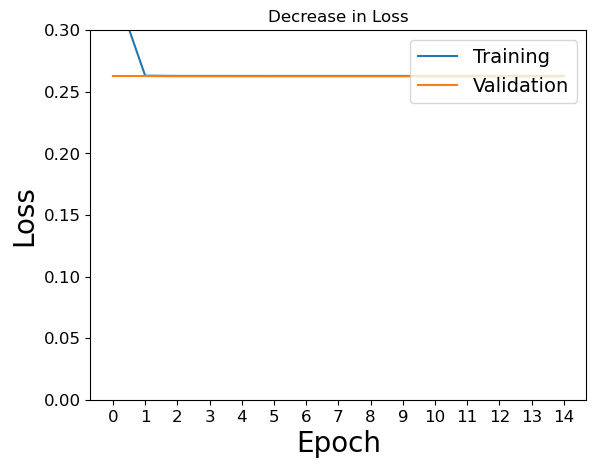

In [11]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_ylim(0, 0.3)
plt.show()

# Plotting the latent space

2D latent space

In [12]:
x_data = []
y_data = []

for number in range(10):
    images = np.load(f'./split_by_number/{number}_images.npy')
    images_reshaped = images.reshape(-1, 28 * 28)

    encoded_imgs = encoder.predict(images_reshaped)

    x_data.append(encoded_imgs[:, 0])
    y_data.append(encoded_imgs[:, 1])

186/186 [==============================] - 0s 2ms/step


3D latent space 

In [ ]:
# x_data = []
# y_data = []
# z_data = []

# for number in range(10):
#     images = np.load(f'./split_by_number/{number}_images.npy')
#     images_reshaped = images.reshape(-1, 28 * 28)

#     encoded_imgs = encoder.predict(images_reshaped)

#     x_data.append(encoded_imgs[:, 0])
#     y_data.append(encoded_imgs[:, 1])
#     z_data.append(encoded_imgs[:, 2])

8 pca 2

In [ ]:
n_components = 2

x_data = []
y_data = []

for number in range(10):
    images = np.load(f'./split_by_number/{number}_images.npy')
    images_reshaped = images.reshape(-1, 28 * 28)

    encoded_imgs = encoder.predict(images_reshaped)

    pca = PCA(n_components=n_components)
    pca.fit(encoded_imgs)
    reduced_data = pca.transform(encoded_imgs)

    x_data.append(reduced_data[:, 0])
    y_data.append(reduced_data[:, 1])

## Plot of all images

8 pca 2

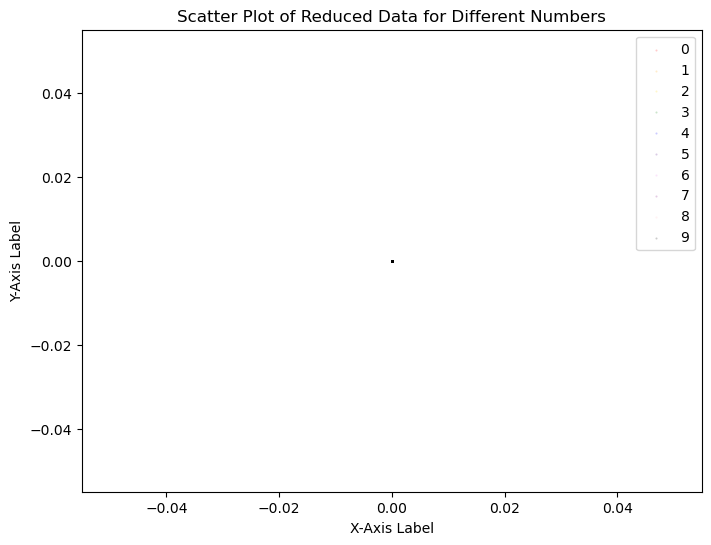

In [17]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig = plt.figure(figsize=(8, 6))

for i in range(10):  # Iterate through the two numbers
    points = np.column_stack((np.hstack(x_data[i]), np.hstack(y_data[i])))
#     hull = ConvexHull(points)
#     convex_hull_vertices = points[hull.vertices]
    plt.scatter(x_data[i], y_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')
#     plt.plot(convex_hull_vertices[:, 0], convex_hull_vertices[:, 1], 'r--', lw=2, label='Convex Hull', c=colors[i])
    
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Scatter Plot of Reduced Data for Different Numbers')
plt.legend()
plt.show()

# # saving the data
# run = '8_pca_2_convex_hull_and_scatter'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

from the graph above it is clear that the images are not clustered by number in the latent space of the autoencoder

In [ ]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig, axes = plt.subplots(2, 5, figsize=(16, 6))

for i in range(10): 
    row = i // 5
    col = i % 5

    axes[row, col].scatter(x_data[i], y_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')
    axes[row, col].set_xlabel('X-Axis Label')
    axes[row, col].set_ylabel('Y-Axis Label')
    axes[row, col].set_title(f'Scatter Plot of {i}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# # saving the data
# run = '8_pca_2_separate_scatters'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

2D latent space

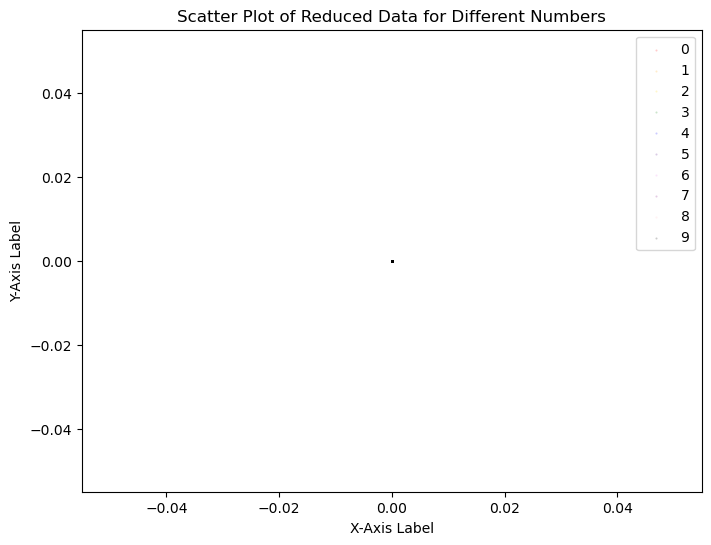

2d_latent_space_convex_hull


In [14]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

fig = plt.figure(figsize=(8, 6))

for i in range(10):  # Iterate through the two numbers
    points = np.column_stack((np.hstack(x_data[i]), np.hstack(y_data[i])))
#     hull = ConvexHull(points)
#     convex_hull_vertices = points[hull.vertices]
    plt.scatter(x_data[i], y_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')
    #plt.plot(convex_hull_vertices[:, 0], convex_hull_vertices[:, 1], 'r--', lw=2, label='Convex Hull', c=colors[i])
    
plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Scatter Plot of Reduced Data for Different Numbers')
plt.legend()
plt.show()

#saving the data
run = '2d_latent_space_convex_hull'
plots_folder_name = 'latent_space_images'
plots_file_name = f'{run}.png'
plots_folder_path = f'latent_space/{plots_folder_name}'
os.makedirs(plots_folder_path, exist_ok=True)
plots_file_path = os.path.join(plots_folder_path, plots_file_name)
fig.savefig(plots_file_path)
plt.show()
print(run)

In [ ]:
# colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

# fig, axes = plt.subplots(2, 5, figsize=(16, 6))

# for i in range(10): 
#     row = i // 5
#     col = i % 5

#     axes[row, col].scatter(x_data[i], y_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')
#     axes[row, col].set_xlabel('X-Axis Label')
#     axes[row, col].set_ylabel('Y-Axis Label')
#     axes[row, col].set_title(f'Scatter Plot of {i}')

# plt.tight_layout()
# plt.show()

# saving the data
# run = '2d_latent_space_separate_scatters'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

3D latent space

In [ ]:
# colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# for i in range(10):
#     ax.scatter(x_data[i], y_data[i], z_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')

# ax.set_xlabel('X-Axis Label')
# ax.set_ylabel('Y-Axis Label')
# ax.set_zlabel('Z-Axis Label')
# ax.set_title('3D Scatter Plot of Reduced Data for Different Numbers')
# ax.legend()
# plt.show()

# # saving the data
# run = '3d_latent_space_all_scatters'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)

In [ ]:
colors = ['red', 'orange', 'gold', 'green', 'blue', 'indigo', 'violet', 'purple', 'pink', 'black']

# fig = plt.figure(figsize=(16, 6))
# fig.suptitle('Grid of 3D Scatter Plots')

# for i in range(10):
#     ax = fig.add_subplot(2, 5, i + 1, projection='3d')  # Create a 3D subplot

#     ax.scatter(x_data[i], y_data[i], z_data[i], c=colors[i], s=1, alpha=0.2, marker='.', label=f'{i}')
#     ax.set_xlabel('X-Axis Label')
#     ax.set_ylabel('Y-Axis Label')
#     ax.set_zlabel('Z-Axis Label')
#     ax.set_title(f'Scatter Plot of {i}')

# plt.tight_layout()
# plt.show()

# # saving the data
# run = '3d_latent_space_separate_scatters'
# plots_folder_name = 'latent_space_images'
# plots_file_name = f'{run}.png'
# plots_folder_path = f'latent_space/{plots_folder_name}'
# os.makedirs(plots_folder_path, exist_ok=True)
# plots_file_path = os.path.join(plots_folder_path, plots_file_name)
# fig.savefig(plots_file_path)
# plt.show()
# print(run)